# Input dataset

In [1]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/root/data/imagenette_wb/train/', # your data here
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False # set True to train the model from scratch
    )

number_of_classes = 10

2023-11-09 15:09:52.218858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 15:09:53.516631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 10475 images belonging to 10 classes.


In [2]:
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    '/root/data/imagenette_wb/val', # your data here
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False # set True to train the model from scratch
    )

Found 3925 images belonging to 10 classes.


# Train from scratch

In [3]:
from keras.applications import ResNet101

model = ResNet101(weights=None,
                 include_top=True,
                 input_shape=(224, 224, 3),
                 classes=number_of_classes)

2023-11-09 15:12:15.987252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:67:02.0, compute capability: 7.0


In [4]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),  
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=105,  # steps = total samples / batch size
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/50


In [38]:
model.save('./model/resnet101.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Using pretrained model

In [4]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('./model/resnet101.h5')

In [6]:
# Use the Global Pooling layer for final features
model.layers[-2]

In [7]:
from keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(train_generator)

2023-11-09 15:12:53.342504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


105/105 [==============================] - 63s 561ms/step


In [8]:
validation_features = feature_extractor.predict(validation_generator)

79/79 [==============================] - 19s 226ms/step


In [9]:
dis_datagen = ImageDataGenerator(rescale=1./255)
distilled_generator = dis_datagen.flow_from_directory(
    '/root/data/syn_data/imagenette/23/',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False)

distilled_features = feature_extractor.predict(distilled_generator)

Found 1000 images belonging to 10 classes.
20/20 [==============================] - 2s 93ms/step


# Visualization

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
                                     
tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=30)
train_features_2d = tsne.fit_transform(train_features)

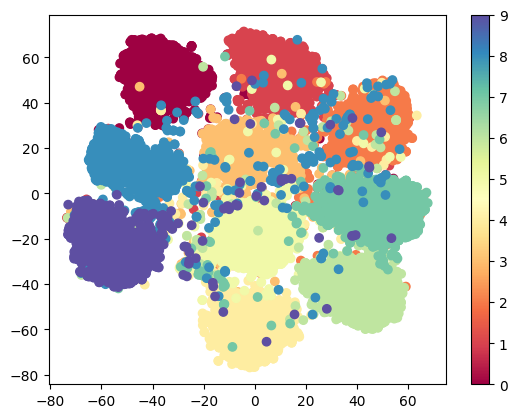

In [11]:
import numpy as np

labels = train_generator.classes

plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=labels, cmap='Spectral')
plt.colorbar()
plt.show()

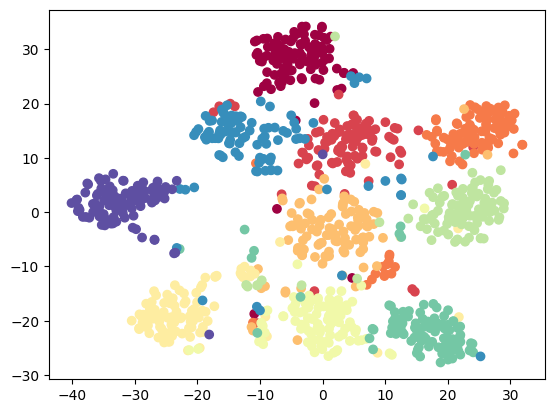

In [12]:
distilled_features_2d = tsne.fit_transform(distilled_features)
labels = distilled_generator.classes
plt.scatter(distilled_features_2d[:, 0], distilled_features_2d[:, 1], c=labels, cmap='Spectral')
plt.show()

## Umap